In [2]:
import sys, yaml
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, lfilter, freqz
from scipy.ndimage import uniform_filter1d
from scipy.optimize import minimize, Bounds
from scipy.stats import fit
from motoman_def import *

In [3]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def dh2v(dh):
    logdh = np.log(dh)
    logv = (logdh-1.647)/-0.4619
    
    v = np.exp(logv)
    return v

def v2dh(v):
    logdh = -0.4619*np.log(v)+1.647
    
    dh = np.exp(logdh)
    return dh

def v2dh_noised(v):
    mod_noise = np.random.rand(2)-0.9
    coeff1_noised = mod_noise[0]*0.05+0.4619
    coeff2_noised = mod_noise[0]*0.5+1.647
    logdh = -coeff1_noised*np.log(v)+coeff2_noised
    
    dh = np.exp(logdh)
    return dh

def avg_by_line(job_line, flame_pos, num_segs):
    ref_idx = job_line[0]
    job_line_unique = [ref_idx]
    idx = 0
    num_points = 0
    average_pos = []
    sum = np.zeros(flame_pos.shape[1])
    while True:
        while job_line[idx] == ref_idx:
            sum = sum + flame_pos[idx,:]
            num_points += 1
            idx+=1
            if idx >= len(job_line): break
        
        average_pos.append(sum/num_points)
        sum = np.zeros(flame_pos.shape[1])
        try:
            ref_idx = job_line[idx]
            job_line_unique.append(ref_idx)
        except:
            break
        num_points = 0
    average_pos = np.array(average_pos)
    output = np.empty((num_segs, 3))
    
    # for i, line_no in enumerate(job_line_unique):
    #     output[line_no,1:] = average_pos[i,:]
    #     output[line_no,0] = line_no
    for i in range(num_segs):
         if i in job_line_unique:
              idx = job_line_unique.index(i)
              output[i,:] = average_pos[idx, :]
         else:
              output[i,:] = [None, None, None]
    #handle missing height data

    return output

def avg_by_line_vel(job_line, cart_vel, num_segs):
    ref_idx = job_line[0]
    job_line_unique = [ref_idx]
    idx = 0
    num_points = 0
    average_pos = []
    sum = 0
    while True:
        while job_line[idx] == ref_idx:
            sum = sum + cart_vel[idx]
            num_points += 1
            idx+=1
            if idx >= len(job_line): break
        
        average_pos.append(sum/num_points)
        sum = 0
        try:
            ref_idx = job_line[idx]
            job_line_unique.append(ref_idx)
        except:
            break
        num_points = 0
    average_pos = np.array(average_pos)
    output = np.empty(num_segs)
    
    # for i, line_no in enumerate(job_line_unique):
    #     output[line_no,1:] = average_pos[i,:]
    #     output[line_no,0] = line_no
    for i in range(num_segs):
         if i in job_line_unique:
              idx = job_line_unique.index(i)
              output[i] = average_pos[idx]
         else:
              output[i] = None
    #handle missing height data

    return output

def calc_cart_vel(robot,joint_angles):
    calc_vel = []
    set_vel = []
    time_series = []
    job_nos = []
    for i in range(joint_angles.shape[0]):

        robot1_pose = robot.fwd(joint_angles[i,2:8])
        cart_dif = robot1_pose.p - pose_prev

        time_stamp = joint_angles[i][0]
        time_dif = time_stamp-time_prev
        time_prev = time_stamp
        cart_vel = cart_dif/time_dif
        time_prev = time_stamp
        pose_prev = robot1_pose.p
        lin_vel = np.sqrt(cart_vel[0]**2+cart_vel[1]**2+cart_vel[2]**2)
        calc_vel.append(lin_vel)
        job_nos.append(joint_angles[i][1])
        try:
            set_vel.append(vel_profile[int(joint_angles[i,1])-job_no_offset])
        except:
            set_vel.append(0)
        time_series.append(time_stamp)
    

class speedHeightModel:
    '''
    Model relating dh to torch speed according to the equation
    ln(h) = a ln(v) + b
    '''
    def __init__(self, lam = 0.05, beta = 1, coeff_mat = [-0.4619, 1.647]):
        # Beta == 1 for non-exponentail updates
        self.coeff_mat = np.array(coeff_mat)
        self.lam = lam
        self.P = np.diag(np.ones(self.coeff_mat.shape[0])*self.lam)
        self.beta = beta
    
    def v2dh(self, v):
        logdh = self.coeff_mat[0]*np.log(v)+self.coeff_mat[1]
    
        dh = np.exp(logdh)
        return dh
    
    def dh2v(self, dh):
        logdh = np.log(dh)
        logv = (logdh-self.coeff_mat[1])/self.coeff_mat[0]
        
        v = np.exp(logv)
        return v
    
    def model_update(self, vels, dhs, weight):
        # Updates the model with new height-torchspeed data
        ln_vels = np.log(np.array(vels))
        ln_dhs = np.log(np.array(dhs))

        # check for nan values in ln(dhs)
        idxs = np.argwhere(np.isnan(ln_dhs))
        ln_dhs = np.delete(ln_dhs, idxs)
        ln_vels = np.delete(ln_vels, idxs)

        # Pseudo-inverse to calculate least squares fit based on new data
        x_mat = np.vstack((ln_vels, np.ones_like(ln_vels)))

        updated_coeff_mat = ln_dhs@np.linalg.pinv(x_mat)
        # print(updated_coeff_mat)
        # print(self.coeff_a)
        # print(self.coeff_b)
        # Model Update
        self.coeff_mat = weight*updated_coeff_mat + (1-weight)*self.coeff_mat
        # else:
        # print(self.coeff_a)
        # print(self.coeff_b)

    def model_update_RLS(self, vels, dhs):
        # Algorithm from https://osquant.com/papers/recursive-least-squares-linear-regression/
        for idx,vel in enumerate(vels):
            x  = np.array([[np.log(np.array(vel))], [1]])
            y = np.log(dhs[idx])
            if not np.isnan(y):
                r = 1+(x.T@self.P@x)/self.beta
                k = self.P@x/(r*self.beta)
                e = y-x.T@self.coeff_mat
                self.coeff_mat = self.coeff_mat+k@e
                self.P = self.P/self.beta-k@k.T*r






In [4]:
dataset='bent_tube/'
sliced_alg='slice_ER_4043/'
data_dir='../data/'+dataset+sliced_alg

config_dir='../config/'
flir_intrinsic=yaml.load(open(config_dir+'FLIR_A320.yaml'), Loader=yaml.FullLoader)
with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
por = slicing_meta['point_of_rotation']
angle = slicing_meta['layer_angle']

with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
base_thickness = slicing_meta['baselayer_thickness']

robot=robot_obj('MA2010_A0',def_path='../config/MA2010_A0_robot_default_config.yml',tool_file_path='../config/torch.csv',\
	pulse2deg_file_path='../config/MA2010_A0_pulse2deg_real.csv',d=15)
robot2=robot_obj('MA1440_A0',def_path='../config/MA1440_A0_robot_default_config.yml',tool_file_path='../config/flir.csv',\
	pulse2deg_file_path='../config/MA1440_A0_pulse2deg_real.csv',base_transformation_file='../config/MA1440_pose.csv')
positioner=positioner_obj('D500B',def_path='../config/D500B_robot_extended_config.yml',tool_file_path='../config/positioner_tcp.csv',\
	pulse2deg_file_path='../config/D500B_pulse2deg_real.csv',base_transformation_file='../config/D500B_pose.csv')

save_path = f'../../recorded_data/ER4043_bent_tube_2024_08_01_11_47_23/'
H = np.loadtxt(data_dir+'curve_pose.csv', delimiter=',')

In [5]:
cart_vel = np.loadtxt(save_path + f'layer_{1}/cart_vel.csv', delimiter=',')
lin_vel = np.sqrt(cart_vel[:,0]**2+cart_vel[:,1]**2+cart_vel[:,2])
print(len(lin_vel))

FileNotFoundError: ../../recorded_data/ER4043_bent_tube_2024_08_01_11_47_23/layer_1/cart_vel.csv not found.

In [ ]:
layer = 50

with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
    flame_3d = pickle.load(file)
with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
    job_no = pickle.load(file)
with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
    flame_3d_prev = pickle.load(file)
with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
    job_no_prev = pickle.load(file)

vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')
cart_vel = np.loadtxt(save_path+f'layer_{layer}/cart_vel.csv', delimiter=',')
lin_vel = np.sqrt(cart_vel[:,0]**2+cart_vel[:,1]**2+cart_vel[:,2])

job_no = [i-4 for i in job_no]
job_no_prev = [i-4 for i in job_no_prev]

p = H[:3, -1]
R = H[:3, :3]

for i in range(flame_3d.shape[0]):
    flame_3d[i] = R.T@flame_3d[i]
for i in range(flame_3d_prev.shape[0]):
    flame_3d_prev[i] = R.T@flame_3d_prev[i]

layer_angle = angle*(layer-1)

layer_angle=np.deg2rad(layer_angle)
new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
flame_3d[:,0] = new_x
flame_3d[:,2] = new_z-base_thickness
new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
flame_3d_prev[:,0] = new_x
flame_3d_prev[:,2] = new_z-base_thickness
averages = avg_by_line(job_no, flame_3d, 50)
average_speed = avg_by_line(job_no, cart_vel, 50)
average_speed = np.sqrt(average_speed[:,0]**2+average_speed[:,1]**2+average_speed[:,2])
heights = averages[:,-1]
averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
heights_prev = averages_prev[:,-1]

# Check Direction Flags so directions match
if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
    heights = heights[::-1]
    vel_profile = vel_profile[::-1]
if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
    heights_prev = heights_prev[::-1]

dh = heights-heights_prev
model = speedHeightModel()
dh_model = model.v2dh(vel_profile)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.linspace(1,50,50), dh)
ax.scatter(np.linspace(1,50,50), dh_model)
# ax.set_aspect('equal')
plt.show()


print("Original coeff mat: ", model.coeff_mat) 
model.model_update(vel_profile[1:-2], dh[1:-2], weight=1)
print("new coeff mat: ", model.coeff_mat) 
print(vel_profile)

FileNotFoundError: ../../recorded_data/ER4043_bent_tube_2024_08_01_11_47_23/layer_50/cart_vel.csv not found.

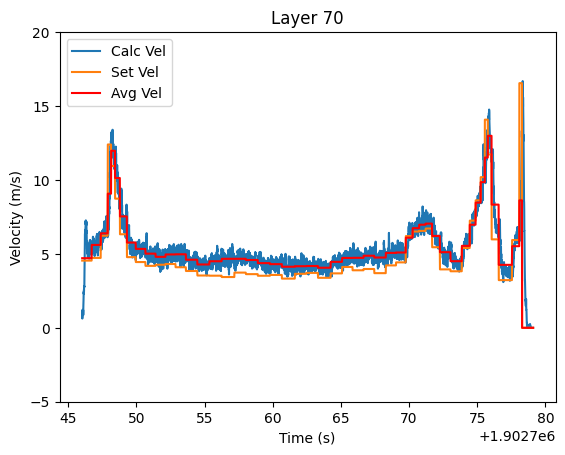

Heights:  [       nan 1.83088622 1.55064236 1.02459387 0.95682808 1.31035173
 1.662013   1.46535566 1.4977542  1.18237134 1.07357959 1.16843932
 1.37010814 1.59367238 1.84098018 1.7648801  1.830077   1.90922476
 1.91676179 2.02798086 2.00547058 2.0147552  2.01878825 2.07147623
 2.0334008  1.97686434 2.00229489 1.93153996 1.95810847 1.9028573
 1.77217206 1.78841342 1.6974804  1.61204729 1.44428095 1.40758227
 1.30645466 1.14542245 1.22833709 1.23385526 1.32471912 1.39695622
 1.82303277 1.98757578 2.00650867 1.58216765 1.60880831 1.50856778
 1.2694969  1.18498086]
Heights prev:  [-0.89930627 -0.83293532 -0.49987987  0.13590114  0.08105117 -0.06005892
 -0.31647299 -0.57231073 -0.60205766 -0.61678904 -0.5330489  -0.45647813
 -0.46157449 -0.48505541 -0.5397152  -0.49054813 -0.4772205  -0.31730061
 -0.31608991 -0.32483489 -0.27758671 -0.35905827 -0.21786211 -0.19132519
 -0.3246858  -0.21828199 -0.0912247  -0.19009502 -0.19410338 -0.33066939
 -0.20238415 -0.19306232  0.13548862  0.12799683  0

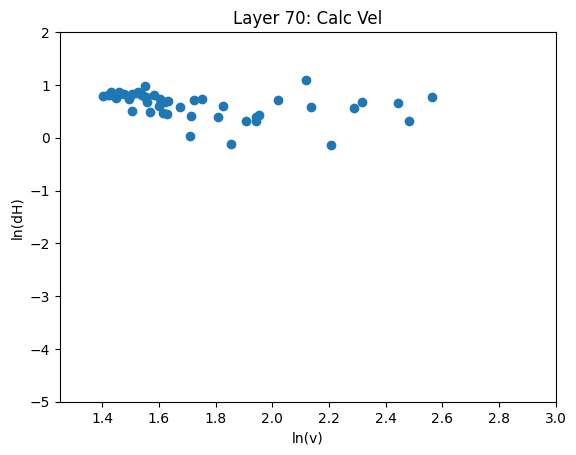

Coefficients:  [-0.32684455  1.15497407]


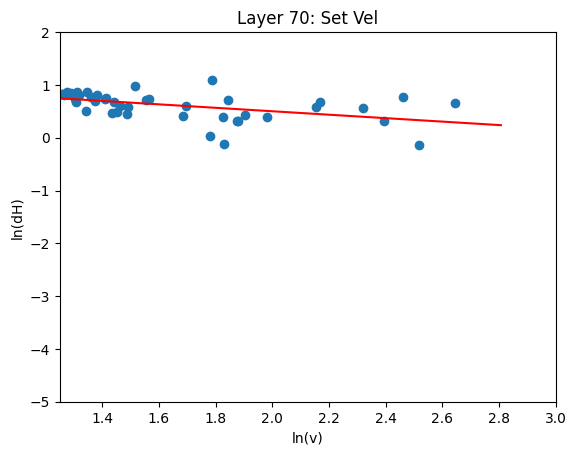

In [15]:
layer = 70

job_no_offset = 3
vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')
joint_angles = np.loadtxt(save_path+f'layer_{layer}/weld_js_exe.csv', delimiter=',')
with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
    job_no_prev = pickle.load(file)
with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
    job_no = pickle.load(file)
with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
    flame_3d = pickle.load(file)
with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
    flame_3d_prev = pickle.load(file)

job_no = [i-3 for i in job_no]
job_no_prev = [i-3 for i in job_no_prev]
# find starting line number 3
try:
    joint_idx_start = np.where(joint_angles[:,1]==job_no_offset)[0][0]
except:
    joint_idx_start = np.where(joint_angles[:,1]==job_no_offset+1)[0][0]
joint_angles_prev = joint_angles[joint_idx_start-1,:]
joint_angles = joint_angles[joint_idx_start:,:]
pose_prev=robot.fwd(joint_angles_prev[2:8]).p
time_prev = joint_angles_prev[0]

calc_vel = []
set_vel = []
time_series = []
job_nos = []
for i in range(joint_angles.shape[0]):
# calculate instantatneous velocity
    robot1_pose = robot.fwd(joint_angles[i,2:8])
    cart_dif = robot1_pose.p - pose_prev

    time_stamp = joint_angles[i][0]
    time_dif = time_stamp-time_prev
    time_prev = time_stamp
    cart_vel = cart_dif/time_dif
    time_prev = time_stamp
    pose_prev = robot1_pose.p
    lin_vel = np.sqrt(cart_vel[0]**2+cart_vel[1]**2+cart_vel[2]**2)
    calc_vel.append(lin_vel)
    job_nos.append(joint_angles[i][1])
    try:
        set_vel.append(vel_profile[int(joint_angles[i,1])-job_no_offset])
    except:
        set_vel.append(0)
    time_series.append(time_stamp)
job_nos = [i-job_no_offset for i in job_nos]
vel_avg = avg_by_line_vel(job_nos, calc_vel, 50)

vel_avgs = []
for i in job_nos:
    try:
        vel_avgs.append(vel_avg[int(i)])
    except:
        vel_avgs.append(0)
p = H[:3, -1]
R = H[:3, :3]

for i in range(flame_3d.shape[0]):
    flame_3d[i] = R.T@flame_3d[i]
for i in range(flame_3d_prev.shape[0]):
    flame_3d_prev[i] = R.T@flame_3d_prev[i]

layer_angle = angle*(layer-1)

layer_angle=np.deg2rad(layer_angle)
new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
flame_3d[:,0] = new_x
flame_3d[:,2] = new_z-base_thickness
new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
flame_3d_prev[:,0] = new_x
flame_3d_prev[:,2] = new_z-base_thickness
averages = avg_by_line(job_no, flame_3d, 50)
heights = averages[:,-1]
averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
heights_prev = averages_prev[:,-1]

if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
    heights = heights[::-1]
    vel_profile = vel_profile[::-1]
    vel_avg = vel_avg[::-1]
if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
    heights_prev = heights_prev[::-1]
    
calc_vel = np.array(calc_vel)
filter_vel = uniform_filter1d(calc_vel, 10)


#plt.plot(calc_vel)
plt.plot(time_series,filter_vel)
plt.plot(time_series,set_vel)
plt.plot(time_series,vel_avgs,'r')

plt.gca().set_ylim(-5,20)
plt.gca().set_title(f'Layer {layer}')
plt.gca().set_xlabel('Time (s)')
plt.gca().set_ylabel('Velocity (m/s)')
plt.gca().legend(('Calc Vel', 'Set Vel', 'Avg Vel'))
plt.show()

dh = heights-heights_prev
print("Heights: ", heights)
print("Heights prev: ", heights_prev)

print("DH: ",dh)
print("Average vel: ", vel_avg)
model = speedHeightModel()

#Calculated Velocity
model.model_update(vel_avg, dh, weight=1)
v_range = [np.min(vel_avg), np.max(vel_avg)]
dh_fit = model.v2dh(v_range)
print("Coefficients: ", model.coeff_mat)
fig, ax = plt.subplots()
ax.scatter(np.log(vel_avg),np.log(dh))
ax.plot(np.log(v_range), np.log(dh_fit), 'r')
ax.set_title(f"Layer {layer}: Calc Vel")
ax.set_ylabel("ln(dH)")
ax.set_xlabel("ln(v)")
ax.set_ylim(-5,2)
ax.set_xlim(1.25,3)
plt.show()
model.model_update(vel_profile, dh, weight=1)
v_range = [np.min(vel_profile), np.max(vel_profile)]
dh_fit = model.v2dh(v_range)
print("Coefficients: ", model.coeff_mat)
fig, ax = plt.subplots()
ax.scatter(np.log(vel_profile),np.log(dh))
ax.plot(np.log(v_range), np.log(dh_fit), 'r')
ax.set_title(f"Layer {layer}: Set Vel")
ax.set_ylabel("ln(dH)")
ax.set_xlabel("ln(v)")
ax.set_ylim(-5,2)
ax.set_xlim(1.25,3)
plt.show()

C:\Users\Jack\AppData\Local\Temp\ipykernel_19324\3309152142.py:166: RuntimeWarning: invalid value encountered in log
  ln_dhs = np.log(np.array(dhs))


Layer 2 Coefficients:  [0.14926806 0.05268507]
Layer 3 Coefficients:  [0.05499316 0.01941017]
Layer 4 Coefficients:  [0.04202406 0.01483265]
Layer 5 Coefficients:  [-0.05222109 -0.01843175]
Layer 6 Coefficients:  [-0.02829793 -0.00998793]
Layer 7 Coefficients:  [0.05214387 0.0184045 ]
Layer 8 Coefficients:  [ 1.06994339 -2.57098805]
Layer 9 Coefficients:  [ 0.42625227 -0.44652852]
Layer 10 Coefficients:  [0.15814314 0.16261539]
Layer 11 Coefficients:  [-0.2246195   1.23829515]
Layer 12 Coefficients:  [-0.37064711  1.33518687]
Layer 13 Coefficients:  [-0.38198798  1.49758002]
Layer 14 Coefficients:  [-0.45264     1.50052523]
Layer 15 Coefficients:  [-0.213062    1.11515234]
Layer 16 Coefficients:  [-0.09558336  0.74735507]
Layer 17 Coefficients:  [-0.41377949  1.41731013]
Layer 18 Coefficients:  [-0.07254986  0.82191691]
Layer 19 Coefficients:  [-0.15131167  1.10135575]
Layer 20 Coefficients:  [-0.12604688  0.58106518]
Layer 21 Coefficients:  [-0.97911489  2.14695235]
Layer 22 Coefficie

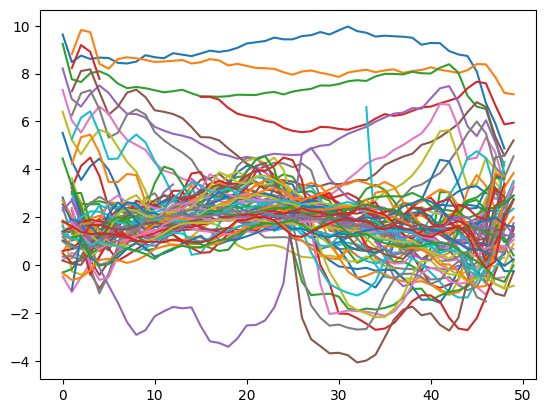

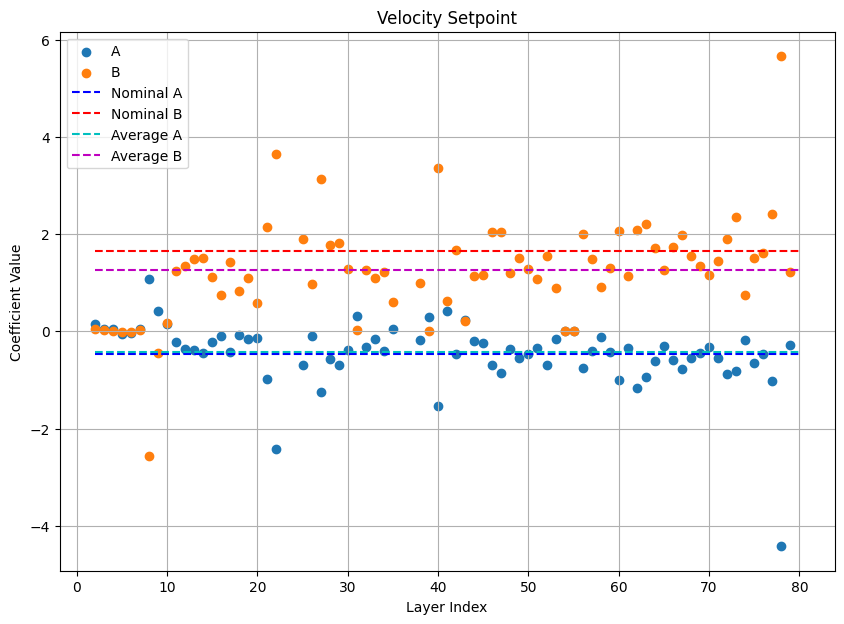

Max A:  1.0699433911521783
Min A:  -4.4181735655668035
Max B:  5.658866626752337
Min B:  -2.5709880474934454


In [ ]:
layer_start = 2
coeff_a = []
coeff_b = []
coeff_a_total = []
coeff_b_total = []
model = speedHeightModel()
model_each_layer = speedHeightModel()
nom_coeff_a = model.coeff_mat[0]
nom_coeff_b = model.coeff_mat[1]
fig,ax = plt.subplots()
for layer in range(layer_start,80):
    try:
        with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
            flame_3d = pickle.load(file)
        with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
            job_no = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
            flame_3d_prev = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
            job_no_prev = pickle.load(file)

        
        
        vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')
        job_no = [i-job_no_offset for i in job_no]
        job_no_prev = [i-job_no_offset for i in job_no_prev]

        p = H[:3, -1]
        R = H[:3, :3]

        for i in range(flame_3d.shape[0]):
            flame_3d[i] = R.T@flame_3d[i]
        for i in range(flame_3d_prev.shape[0]):
            flame_3d_prev[i] = R.T@flame_3d_prev[i]

        layer_angle = angle*(layer-1)

        layer_angle=np.deg2rad(layer_angle)
        new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
        flame_3d[:,0] = new_x
        flame_3d[:,2] = new_z-base_thickness
        new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
        flame_3d_prev[:,0] = new_x
        flame_3d_prev[:,2] = new_z-base_thickness
        averages = avg_by_line(job_no, flame_3d, 50)
        heights = averages[:,-1]
        averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
        heights_prev = averages_prev[:,-1]

        # Check Direction Flags so directions match
        if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
            heights = heights[::-1]
            vel_profile = vel_profile[::-1]
        if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
            heights_prev = heights_prev[::-1]
        ax.plot(heights)
        dh = heights-heights_prev
        dh_model = model.v2dh(vel_profile)
        # fig, ax = plt.subplots()
        # ax.scatter(np.log(vel_profile),np.log(dh))
        # ax.set_title(f"Layer {layer}")
        # plt.show()
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.scatter(np.linspace(1,50,50), dh)
        # ax.scatter(np.linspace(1,50,50), dh_model)
        # ax.set_aspect('equal')
        # plt.show()

        # print("Original A coeff: ", model.coeff_a)
        # print("Original B coeff: ", model.coeff_b)
        
        weight = 1
        model.model_update(vel_profile, dh, weight=weight)
        model_each_layer.model_update(vel_profile, dh, weight = 1)
        print(f"Layer {layer} Coefficients: ", model.coeff_mat)
        # print("New A coeff: ", model.coeff_a)
        # print("New B coeff: ", model.coeff_b)
        coeff_a.append(model.coeff_mat[0])
        coeff_b.append(model.coeff_mat[1])
        coeff_a_total.append(model_each_layer.coeff_mat[0])
        coeff_b_total.append(model_each_layer.coeff_mat[1])

    except IndexError:
        coeff_a.append(None)
        coeff_b.append(None)
        pass
plt.show()
average_a = np.average(coeff_a_total)
average_b = np.average(coeff_b_total)

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a)-1,len(coeff_a)), coeff_a)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b)-1,len(coeff_b)), coeff_b)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.plot([layer_start, layer_start+len(coeff_b)], [average_a, average_a], 'c--')
plt.plot([layer_start, layer_start+len(coeff_b)], [average_b, average_b], 'm--')
plt.legend(("A", "B", "Nominal A", "Nominal B", "Average A", "Average B"))
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
# plt.gca().set_ylim(-4.1,4.1)
plt.title(f"Velocity Setpoint")
plt.show()

# plt.plot(coeff_a_total)
# plt.plot(coeff_b_total)
print("Max A: ", max(coeff_a_total))
print("Min A: ", min(coeff_a_total))
print("Max B: ", max(coeff_b_total))
print("Min B: ", min(coeff_b_total))

np.savetxt("model_coeffs_real.csv", np.array([coeff_a_total, coeff_b_total]).T, delimiter=',')

C:\Users\Jack\AppData\Local\Temp\ipykernel_12112\1984905654.py:141: RuntimeWarning: invalid value encountered in log
  ln_dhs = np.log(np.array(dhs))


Layer 2 Coefficients:  [-0.19379063  0.83414541]
Layer 3 Coefficients:  [ 0.77442173 -1.26496818]
Layer 4 Coefficients:  [ 0.74401912 -1.23763496]
Layer 5 Coefficients:  [ 1.36442719 -2.58103776]
Layer 6 Coefficients:  [ 0.28044902 -0.6630708 ]
Layer 7 Coefficients:  [ 1.46811945 -2.65227229]
Layer 8 Coefficients:  [ 0.43392787 -0.52300835]
Layer 9 Coefficients:  [ 0.51839794 -0.49822959]
Layer 10 Coefficients:  [ 0.74000252 -0.97731644]
Layer 11 Coefficients:  [-0.04090851  0.90063185]
Layer 12 Coefficients:  [-0.10010234  0.86477509]
Layer 13 Coefficients:  [0.21972584 0.31543373]
Layer 14 Coefficients:  [-0.46406955  1.48063491]
Layer 15 Coefficients:  [0.13701634 0.41699951]
Layer 16 Coefficients:  [-0.38121006  1.27974993]
Layer 17 Coefficients:  [-0.33825341  1.34694157]
Layer 18 Coefficients:  [-0.46188006  1.56234777]
Layer 19 Coefficients:  [-0.33852507  1.44777765]
Layer 20 Coefficients:  [ 0.33235905 -0.44130585]
Layer 21 Coefficients:  [ 1.0242932  -1.07845162]
Layer 22 Coe

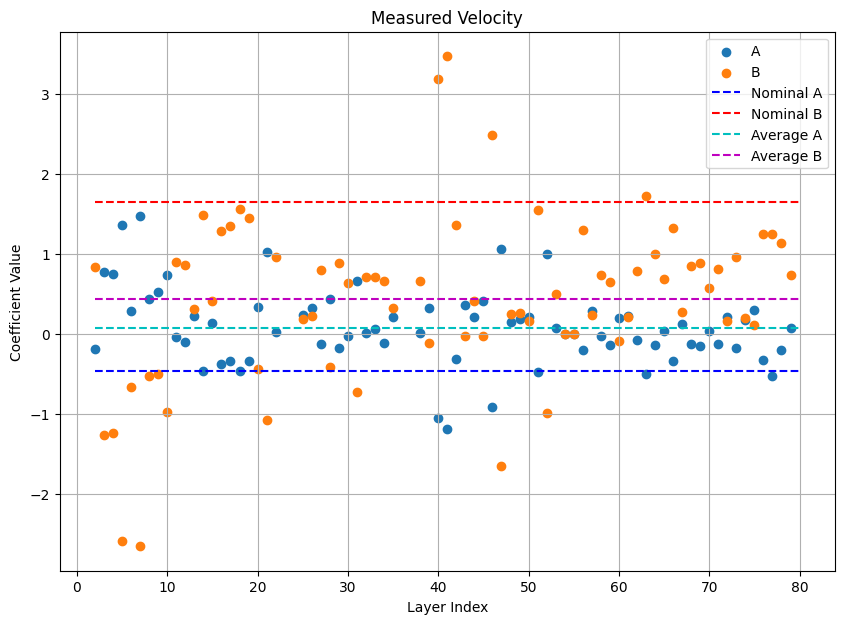

Max A:  1.4681194504444042
Min A:  -1.1832234488415576
Max B:  3.468865950541343
Min B:  -2.6522722862632246


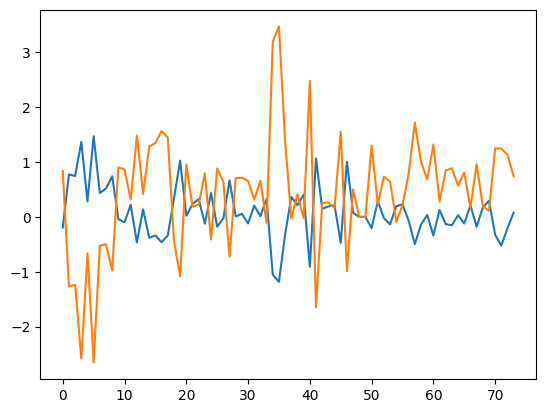

In [ ]:
layer_start = 2
coeff_a = []
coeff_b = []
coeff_a_total = []
coeff_b_total = []
model = speedHeightModel()
model_each_layer = speedHeightModel()
nom_coeff_a = model.coeff_mat[0]
nom_coeff_b = model.coeff_mat[1]
for layer in range(layer_start,80):
    try:
        with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
            flame_3d = pickle.load(file)
        with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
            job_no = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
            flame_3d_prev = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
            job_no_prev = pickle.load(file)
        vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')

        calc_vel = []
        set_vel = []
        time_series = []
        job_nos = []
        for i in range(joint_angles.shape[0]):
        # calculate instantatneous velocity
            robot1_pose = robot.fwd(joint_angles[i,2:8])
            cart_dif = robot1_pose.p - pose_prev

            time_stamp = joint_angles[i][0]
            time_dif = time_stamp-time_prev
            time_prev = time_stamp
            cart_vel = cart_dif/time_dif
            time_prev = time_stamp
            pose_prev = robot1_pose.p
            lin_vel = np.sqrt(cart_vel[0]**2+cart_vel[1]**2+cart_vel[2]**2)
            calc_vel.append(lin_vel)
            job_nos.append(joint_angles[i][1])
            try:
                set_vel.append(vel_profile[int(joint_angles[i,1])-job_no_offset])
            except:
                    set_vel.append(0)
            time_series.append(time_stamp)
        job_nos = [i-job_no_offset for i in job_nos]
        vel_avg = avg_by_line_vel(job_nos, calc_vel, 50)
        
        
        job_no = [i-job_no_offset for i in job_no]
        job_no_prev = [i-job_no_offset for i in job_no_prev]

        p = H[:3, -1]
        R = H[:3, :3]

        for i in range(flame_3d.shape[0]):
            flame_3d[i] = R.T@flame_3d[i]
        for i in range(flame_3d_prev.shape[0]):
            flame_3d_prev[i] = R.T@flame_3d_prev[i]

        layer_angle = angle*(layer-1)

        layer_angle=np.deg2rad(layer_angle)
        new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
        flame_3d[:,0] = new_x
        flame_3d[:,2] = new_z-base_thickness
        new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
        flame_3d_prev[:,0] = new_x
        flame_3d_prev[:,2] = new_z-base_thickness
        averages = avg_by_line(job_no, flame_3d, 50)
        heights = averages[:,-1]
        averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
        heights_prev = averages_prev[:,-1]

        # Check Direction Flags so directions match
        if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
            heights = heights[::-1]
            vel_profile = vel_profile[::-1]
            vel_avg = vel_avg[::-1]
        if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
            heights_prev = heights_prev[::-1]

        dh = heights-heights_prev
        dh_model = model.v2dh(vel_profile)
        # fig, ax = plt.subplots()
        # ax.scatter(np.log(vel_profile),np.log(dh))
        # ax.set_title(f"Layer {layer}")
        # plt.show()
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.scatter(np.linspace(1,50,50), dh)
        # ax.scatter(np.linspace(1,50,50), dh_model)
        # ax.set_aspect('equal')
        # plt.show()

        # print("Original A coeff: ", model.coeff_a)
        # print("Original B coeff: ", model.coeff_b)
        
        weight = 1
        model.model_update(vel_avg, dh, weight=weight)
        model_each_layer.model_update(vel_avg, dh, weight = 1)
        # print("New A coeff: ", model.coeff_a)
        # print("New B coeff: ", model.coeff_b)
        coeff_a.append(model.coeff_mat[0])
        coeff_b.append(model.coeff_mat[1])
        coeff_a_total.append(model_each_layer.coeff_mat[0])
        coeff_b_total.append(model_each_layer.coeff_mat[1])

        print(f"Layer {layer} Coefficients: ", model.coeff_mat)

    except IndexError:
        coeff_a.append(None)
        coeff_b.append(None)
        pass

average_a = np.average(coeff_a_total)
average_b = np.average(coeff_b_total)

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a)-1,len(coeff_a)), coeff_a)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b)-1,len(coeff_b)), coeff_b)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.plot([layer_start, layer_start+len(coeff_b)], [average_a, average_a], 'c--')
plt.plot([layer_start, layer_start+len(coeff_b)], [average_b, average_b], 'm--')
plt.legend(("A", "B", "Nominal A", "Nominal B", "Average A", "Average B"))
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
# plt.gca().set_ylim(-4.1,4.1)
plt.title(f"Measured Velocity")
plt.show()

plt.plot(coeff_a_total)
plt.plot(coeff_b_total)
print("Max A: ", max(coeff_a_total))
print("Min A: ", min(coeff_a_total))
print("Max B: ", max(coeff_b_total))
print("Min B: ", min(coeff_b_total))

np.savetxt("model_coeffs_real.csv", np.array([coeff_a_total, coeff_b_total]).T, delimiter=',')

C:\Users\Jack\AppData\Local\Temp\ipykernel_12112\1984905654.py:165: RuntimeWarning: invalid value encountered in log
  y = np.log(dhs[idx])


too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
Final Coefficient Matrix:  [-0.35617537  1.2758658 ]
(2,)


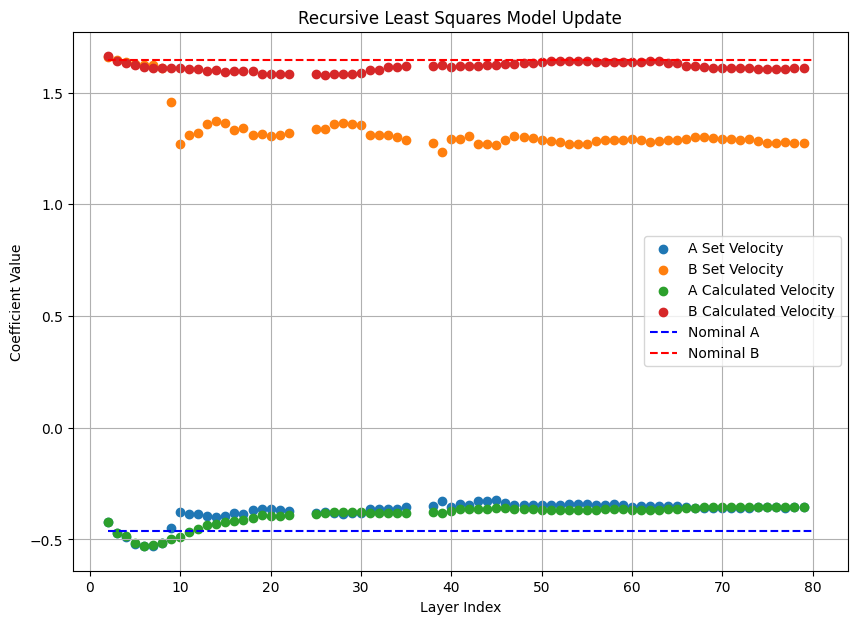

In [ ]:
layer_start = 2
layer_end = 80
coeff_a = []
coeff_b = []
coeff_a_total = []
coeff_b_total = []
coeff_a_real = []
coeff_b_real = []
model = speedHeightModel()
model_real = speedHeightModel()
nom_coeff_a = model.coeff_mat[0]
nom_coeff_b = model.coeff_mat[1]
for layer in range(layer_start,layer_end):
    try:
        with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
            flame_3d = pickle.load(file)
        with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
            job_no = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
            flame_3d_prev = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
            job_no_prev = pickle.load(file)
        # find starting line number 3
        joint_idx_start = np.where(joint_angles[:,1]==job_no_offset)[0][0]
        joint_angles_prev = joint_angles[joint_idx_start-1,:]
        joint_angles = joint_angles[joint_idx_start:,:]
        pose_prev=robot.fwd(joint_angles_prev[2:8]).p
        time_prev = joint_angles_prev[0]

        calc_vel = []
        set_vel = []
        time_series = []
        job_nos = []
        for i in range(joint_angles.shape[0]):
        # calculate instantatneous velocity
            robot1_pose = robot.fwd(joint_angles[i,2:8])
            cart_dif = robot1_pose.p - pose_prev

            time_stamp = joint_angles[i][0]
            time_dif = time_stamp-time_prev
            time_prev = time_stamp
            cart_vel = cart_dif/time_dif
            time_prev = time_stamp
            pose_prev = robot1_pose.p
            lin_vel = np.sqrt(cart_vel[0]**2+cart_vel[1]**2+cart_vel[2]**2)
            calc_vel.append(lin_vel)
            job_nos.append(joint_angles[i][1])
            try:
                set_vel.append(vel_profile[int(joint_angles[i,1])-job_no_offset])
            except:
                    set_vel.append(0)
            time_series.append(time_stamp)
        job_nos = [i-job_no_offset for i in job_nos]
        vel_avg = avg_by_line_vel(job_nos, calc_vel, 50)

        vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')
        job_no = [i-job_no_offset for i in job_no]
        job_no_prev = [i-job_no_offset for i in job_no_prev]

        p = H[:3, -1]
        R = H[:3, :3]

        for i in range(flame_3d.shape[0]):
            flame_3d[i] = R.T@flame_3d[i]
        for i in range(flame_3d_prev.shape[0]):
            flame_3d_prev[i] = R.T@flame_3d_prev[i]

        layer_angle = angle*(layer-1)

        layer_angle=np.deg2rad(layer_angle)
        new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
        flame_3d[:,0] = new_x
        flame_3d[:,2] = new_z-base_thickness
        new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
        flame_3d_prev[:,0] = new_x
        flame_3d_prev[:,2] = new_z-base_thickness
        averages = avg_by_line(job_no, flame_3d, 50)
        heights = averages[:,-1]
        averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
        heights_prev = averages_prev[:,-1]

        # Check Direction Flags so directions match
        if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
            heights = heights[::-1]
            vel_profile = vel_profile[::-1]
            vel_avg = vel_avg[::-1]
        if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
            heights_prev = heights_prev[::-1]

        dh = heights-heights_prev
        dh_model = model.v2dh(vel_profile)

        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.scatter(np.linspace(1,50,50), dh)
        # ax.scatter(np.linspace(1,50,50), dh_model)
        # ax.set_aspect('equal')
        # plt.show()

        # print("Original A coeff: ", model.coeff_a)
        # print("Original B coeff: ", model.coeff_b)
        
        model.model_update_RLS(vel_profile[1:-2], dh[1:-2])
        model_real.model_update_RLS(vel_avg[1:-2], dh[1:-2])
        # print("New A coeff: ", model.coeff_a)
        # print("New B coeff: ", model.coeff_b)
        coeff_a.append(model.coeff_mat[0])
        coeff_b.append(model.coeff_mat[1])
        coeff_a_real.append(model_real.coeff_mat[0])
        coeff_b_real.append(model_real.coeff_mat[1])

    except IndexError as e:
        print(e)
        coeff_a.append(None)
        coeff_b.append(None)
        coeff_a_real.append(None)
        coeff_b_real.append(None)
        pass

print("Final Coefficient Matrix: ", model.coeff_mat)
print(model.coeff_mat.shape)

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a)-1,len(coeff_a)), coeff_a)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b)-1,len(coeff_b)), coeff_b)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a_real)-1,len(coeff_a_real)), coeff_a_real)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b_real)-1,len(coeff_b_real)), coeff_b_real)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.legend(("A Set Velocity", "B Set Velocity","A Calculated Velocity", "B Calculated Velocity", "Nominal A", "Nominal B", "Average A", "Average B"))
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
plt.title(f"Recursive Least Squares Model Update")
plt.show()

# np.savetxt("model_coeffs_RLS.csv", np.array([coeff_a_real, coeff_b_real]).T, delimiter=',')

In [ ]:
print("starting")
num_layers = 80
part_len = 50 #mm
v_min = 5
max_dH = v2dh(v_min)
v_max = 15
min_dH = v2dh(v_max)
points_per_layer = 50

layer_angle = np.arcsin((max_dH-min_dH)/part_len)
rot_point = max_dH/np.tan(layer_angle)-part_len/2
print(np.rad2deg(layer_angle))
print(rot_point)
print(max_dH)
print(min_dH)
print(np.rad2deg(num_layers*layer_angle))

starting
1.1257976619508032
100.6131657840027
2.468475190539253
1.4860946104132609
90.06381295606425


In [ ]:
# Model Setup
def delta_v(v):
    delta_v = [v[i]-v[i+1] for i in range(len(v)-1)]
    return delta_v
def v_opt(v_next, v_prev, h_err, h_targ, lam, beta):
    return norm(h_targ+h_err-v2dh(v_next), 2)**2 + lam*norm(v_next-v_prev, 2)**2 + beta*norm(delta_v(v_next), 2)**2

noisy_model = np.loadtxt("model_coeffs_real.csv", delimiter=',')
noisy_coeff_a = noisy_model[:,0]
noisy_coeff_b = noisy_model[:,1]
np.random.shuffle(noisy_coeff_a)
np.random.shuffle(noisy_coeff_b)
print(np.mean(noisy_coeff_a))
print(np.mean(noisy_coeff_b))

-1.0646415244625564
2.0997112406343303


Final Height Error:  13.950250651629132


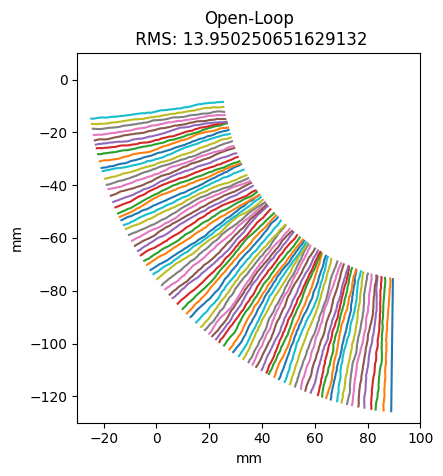

In [ ]:
np.random.seed(1234)
def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)*5
    #noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/20)), 10, mode='interp')
    noise_profile = uniform_filter1d(noise+nom_profile, 20)
    # noise_profile = noise+nom_profile
    return noise_profile
# nominal layer plot
layers = []
x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
height_profile = np.linspace(max_dH, min_dH, points_per_layer)
vel_nom = dh2v(height_profile)

curve_curved=np.zeros((num_layers*points_per_layer,2))
new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
# first layer
curve_curved[:points_per_layer, 0] = x_vals
curve_curved[:points_per_layer, 1] = v2dh_noised(vel_nom)+10
offset = 0
for i in range(1,num_layers):
    if not(coeff_a[i-offset] == None or coeff_b[i-offset] == None):
        model = speedHeightModel(coeff_mat=[coeff_a[i], coeff_b[i]])
    else:
        model = speedHeightModel(coeff_mat=model.coeff_mat)
        offset += 1
    new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
    curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(model.v2dh(vel_nom)+curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])
#final rotation
curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
final_error = np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                      len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]))
print("Final Height Error: ", final_error)
fig,ax = plt.subplots()
for i in range(num_layers):
    ax.plot(curve_curved[i*points_per_layer:(i+1)*points_per_layer,0], curve_curved[i*points_per_layer:(i+1)*points_per_layer,1])
ax.set_aspect('equal')
ax.set_xlim(-30,100)
ax.set_ylim(-130, 10)
ax.set_title(f"Open-Loop\n RMS: {final_error}")
ax.set_xlabel("mm")
ax.set_ylabel("mm")
plt.show()

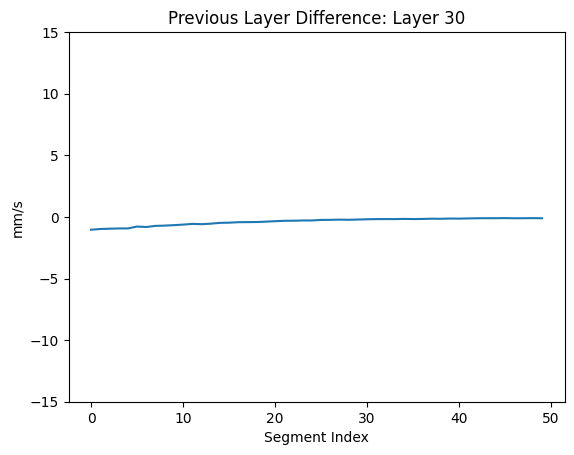

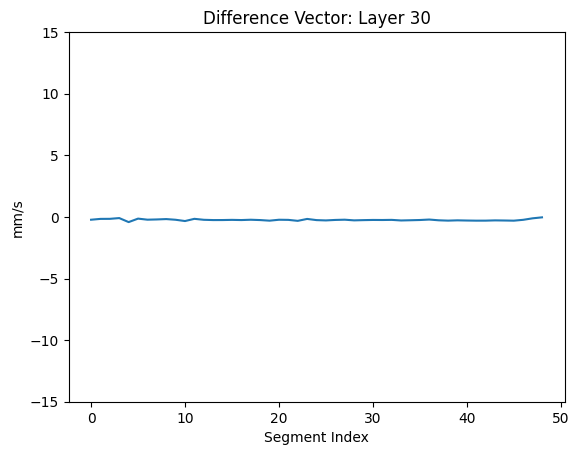

Final Height Error:  1.799100380691045


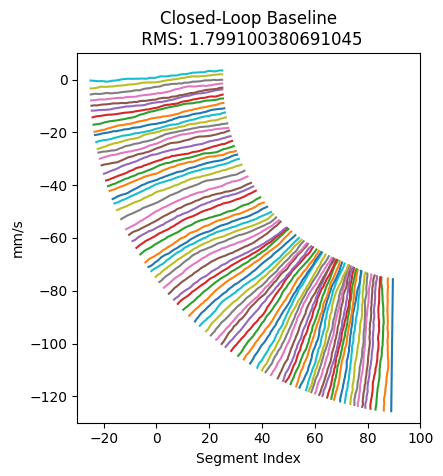

In [ ]:
np.random.seed(1234)
layer_plot = 30
vel_prev = vel_nom
# alpha = 1.32
# beta = 0.95
alpha = 2.0
beta = 0.11
# alpha = 0
# beta = 0
#constraints
bounds = Bounds(3, 17)
def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)*5
    noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/2)), 10, mode='interp')
    noise_profile = uniform_filter1d(noise+nom_profile, 20)
    # noise_profile = noise+nom_profile
    return noise_profile
def measurement_noise(n):
    return (np.random.rand(n)-0.5)*1
# nominal layer plot
layers = []
x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
height_profile = np.linspace(max_dH, min_dH, points_per_layer)
vel_nom = dh2v(height_profile)

curve_curved=np.zeros((num_layers*points_per_layer,2))
new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
# first layer
curve_curved[:points_per_layer, 0] = x_vals
curve_curved[:points_per_layer, 1] = v2dh_noised(vel_nom)+10
offset = 0
fig,ax = plt.subplots()
fig1,ax1 = plt.subplots()
for i in range(1,num_layers):
    if not(coeff_a[i-offset] == None or coeff_b[i-offset] == None):
        model = speedHeightModel(coeff_mat=[coeff_a[i], coeff_b[i]])
    else:
        model = speedHeightModel(coeff_mat=model.coeff_mat)
        offset += 1
    new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
    curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T
    # measure and correct
    height_vals_prev = curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]
    height_err = 0-height_vals_prev+measurement_noise(len(height_vals_prev))
    opt_result=minimize(v_opt, vel_nom, (vel_prev, height_err, height_profile, alpha, beta), bounds=bounds,
                        options = {'maxfun':100000})
    if not opt_result.success: 
        print(opt_result)
        raise ValueError(opt_result.message)
    vel_profile = opt_result.x
    if (i == layer_plot):
        ax.plot(vel_profile-vel_prev)
        ax1.plot(delta_v(vel_profile))

    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(v2dh_noised(vel_profile)+height_vals_prev)

    vel_prev = vel_profile
ax.set_title(f"Previous Layer Difference: Layer {layer_plot}")
ax.set_ylim(-15, 15)
ax.set_xlabel("Segment Index")
ax.set_ylabel("mm/s")
ax1.set_ylim(-15,15)
ax1.set_title(f"Difference Vector: Layer {layer_plot}")
ax1.set_xlabel("Segment Index")
ax1.set_ylabel("mm/s")
plt.show()
#final rotation
curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
final_error = np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                      len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]))
print("Final Height Error: ", final_error)
fig,ax = plt.subplots()
for i in range(num_layers):
    ax.plot(curve_curved[i*points_per_layer:(i+1)*points_per_layer,0], curve_curved[i*points_per_layer:(i+1)*points_per_layer,1])
ax.set_aspect('equal')
ax.set_aspect('equal')
ax.set_xlim(-30,100)
ax.set_ylim(-130, 10)
ax.set_title(f"Closed-Loop Baseline\n RMS: {final_error}")
ax.set_xlabel("Segment Index")
ax.set_ylabel("mm/s")
plt.show()

In [ ]:
alpha = 1.32
beta=0
bounds = Bounds(3, 17)
def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)*4
    noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/2)), 6, mode='nearest')
    noise_profile = uniform_filter1d(noise+nom_profile, 20)
    # noise_profile = noise+nom_profile
    return noise_profile
def measurement_noise(n):
    return (np.random.rand(n)-0.5)*1

for alpha in np.linspace(1,2,10):
    for beta in np.linspace(0,1,10):
        np.random.seed(1234)
        vel_prev = vel_nom
        #constraints
        
        # nominal layer plot
        layers = []
        x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
        height_profile = np.linspace(max_dH, min_dH, points_per_layer)
        vel_nom = dh2v(height_profile)

        curve_curved=np.zeros((num_layers*points_per_layer,2))
        new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
        # first layer
        curve_curved[:points_per_layer, 0] = x_vals
        curve_curved[:points_per_layer, 1] = v2dh_noised(vel_nom)
        offset = 0
        for i in range(1,num_layers):
            if not(coeff_a[i-offset] == None or coeff_b[i-offset] == None):
                model = speedHeightModel(coeff_mat=[coeff_a[i], coeff_b[i]])
            else:
                model = speedHeightModel(coeff_mat=model.coeff_mat)
                offset += 1
            new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
            curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T
            # measure and correct
            height_vals_prev = curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]
            height_err = 0-height_vals_prev+measurement_noise(len(height_vals_prev))
            opt_result=minimize(v_opt, vel_nom, (vel_prev, height_err, height_profile, alpha, beta), bounds=bounds,
                                options = {'maxfun':100000})
            if not opt_result.success: 
                print(opt_result)
                raise ValueError(opt_result.message)
            vel_profile = opt_result.x

            curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
            curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(v2dh_noised(vel_profile)+height_vals_prev)

            vel_prev = vel_profile
        #final rotation
        curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
        final_error = np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                            len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]))
        print(f"Final Height Error at alpha={alpha}, beta={beta}: ", final_error)

        

Final Height Error at alpha=1.0, beta=0.0:  2.396826664151165
Final Height Error at alpha=1.0, beta=0.1111111111111111:  2.398803283264196
Final Height Error at alpha=1.0, beta=0.2222222222222222:  2.4015699458050137
Final Height Error at alpha=1.0, beta=0.3333333333333333:  2.40453100867693
Final Height Error at alpha=1.0, beta=0.4444444444444444:  2.4072140048595565
Final Height Error at alpha=1.0, beta=0.5555555555555556:  2.4096722593813866
Final Height Error at alpha=1.0, beta=0.6666666666666666:  2.4119325757650922
Final Height Error at alpha=1.0, beta=0.7777777777777777:  2.4140137257701793
Final Height Error at alpha=1.0, beta=0.8888888888888888:  2.415948274656184
Final Height Error at alpha=1.0, beta=1.0:  2.4177724197716186
Final Height Error at alpha=1.1111111111111112, beta=0.0:  2.4652544283219004
Final Height Error at alpha=1.1111111111111112, beta=0.1111111111111111:  2.47294705630323
Final Height Error at alpha=1.1111111111111112, beta=0.2222222222222222:  2.4777812536